**Taking Data**

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd

# Load the embeddings and labels
embeddings_1 = np.load('data/embeddings_1.npy')
embeddings_2 = np.load('data/embeddings_2.npy')
labels_1 = [line.strip().split(';') for line in open('data/icd_codes_1.txt')]
labels_2 = [line.strip().split(';') for line in open('data/icd_codes_2.txt')]

# Combine embeddings and labels
X = np.vstack([embeddings_1, embeddings_2])
y = labels_1 + labels_2

# Multi-label binarization of ICD10 codes
mlb = MultiLabelBinarizer()
y_binarized = mlb.fit_transform(y)


In [10]:
# Check the shape of embeddings and labels
print("Shape of combined embeddings:", X.shape)
print("Number of combined labels:", len(y))
print("Shape of binarized labels:", y_binarized.shape)

# Inspect a few entries
print("Sample Embedding:", X[0][:5])  # Print first 5 dimensions of the first embedding
print("Sample Labels:", y[:10])         # Print the ICD10 codes for the first sample


Shape of combined embeddings: (198982, 1024)
Number of combined labels: 198982
Shape of binarized labels: (198982, 1400)
Sample Embedding: [-0.13862878 -0.2293093  -0.6919088   0.17499022 -0.14760579]
Sample Labels: [['H65.23'], ['G89.29', 'M25.562'], ['R13.10', 'K20.90', 'K31.89', 'K25.9', 'K29.80'], ['K20.90', 'R10.11', 'Z86.010', 'K57.30', 'Z90.49'], ['R93.3', 'K29.50', 'R10.84', 'K31.89', 'R19.7'], ['K62.5', 'K64.8', 'K64.5'], ['H25.811'], ['H65.06', 'H65.23', 'H69.83', 'H65.33'], ['H53.8', 'H25.11'], ['Z12.11', 'K57.30', 'K64.1']]


**EDA**

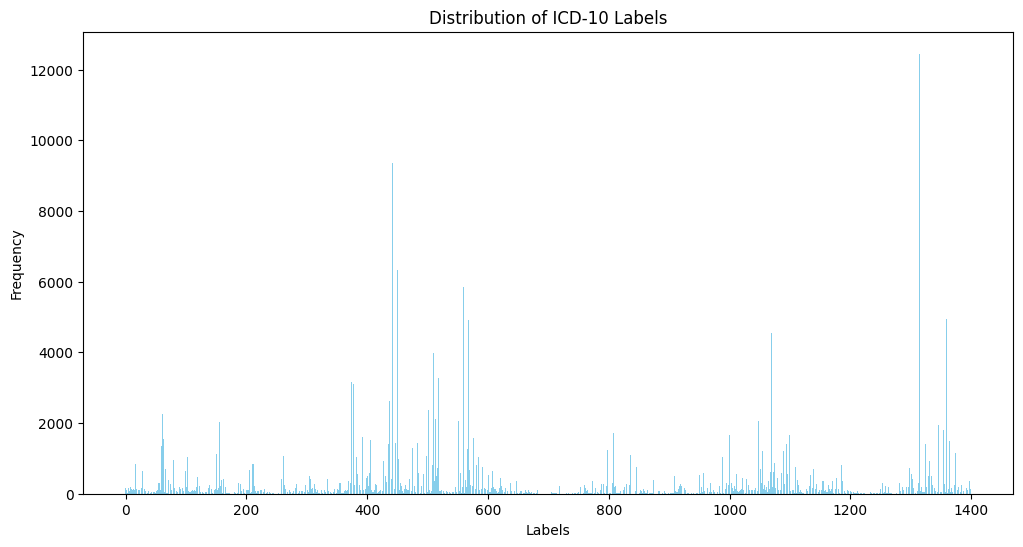

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Sum of occurrences per label
label_counts = y_binarized.sum(axis=0)

# Plot label distribution
plt.figure(figsize=(12, 6))
plt.bar(range(len(label_counts)), label_counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of ICD-10 Labels')
plt.show()


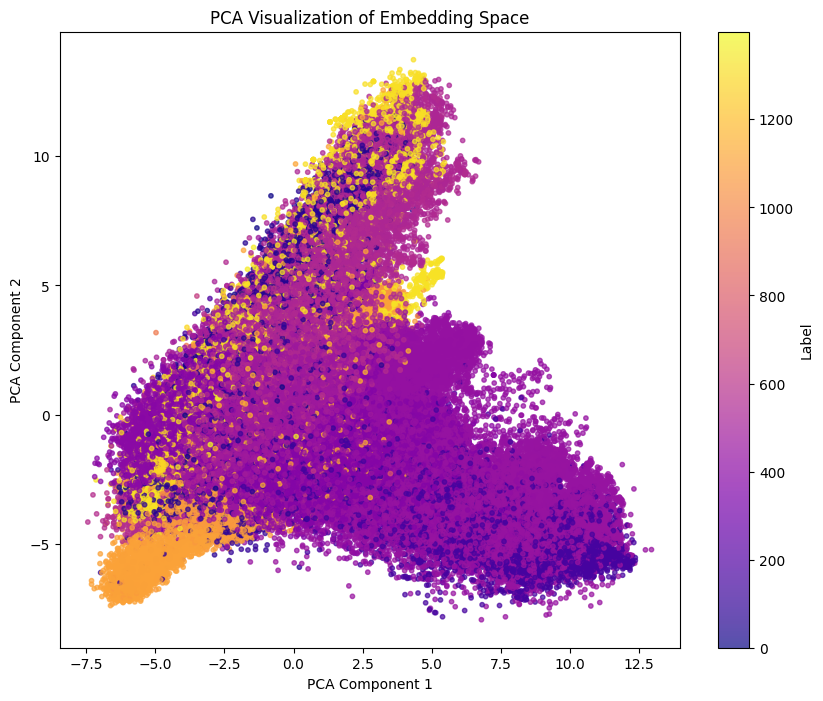

In [13]:
from sklearn.decomposition import PCA

# Reduce to 2 principal components
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

# Plot PCA results
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_binarized.argmax(axis=1), cmap='plasma', s=10, alpha=0.7)
plt.colorbar(label='Label')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of Embedding Space')
plt.show()


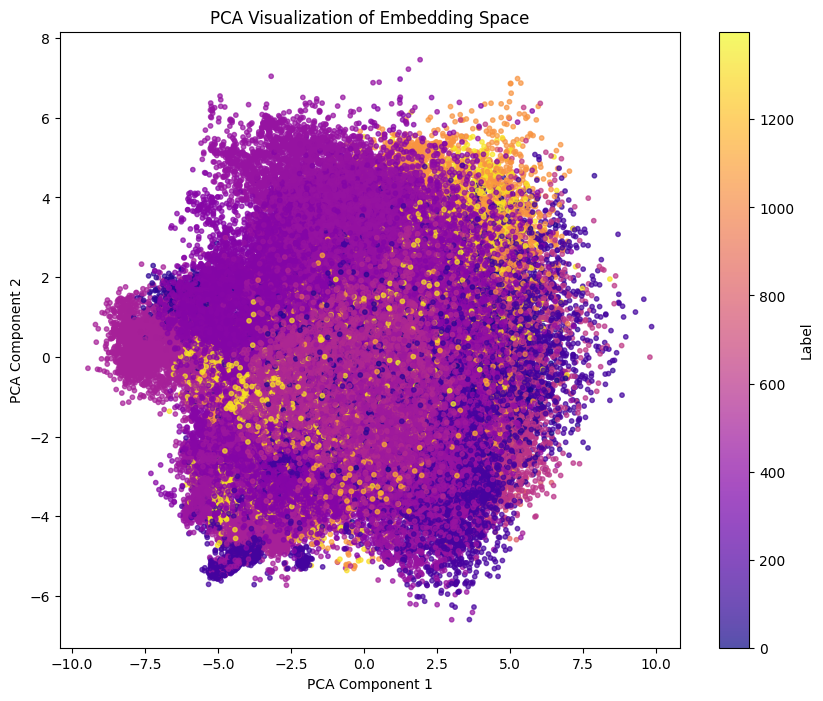

In [15]:
# Plot PCA results
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 5], X_pca[:, 10], c=y_binarized.argmax(axis=1), cmap='plasma', s=10, alpha=0.7)
plt.colorbar(label='Label')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of Embedding Space')
plt.show()

t-SNE Visualisation 

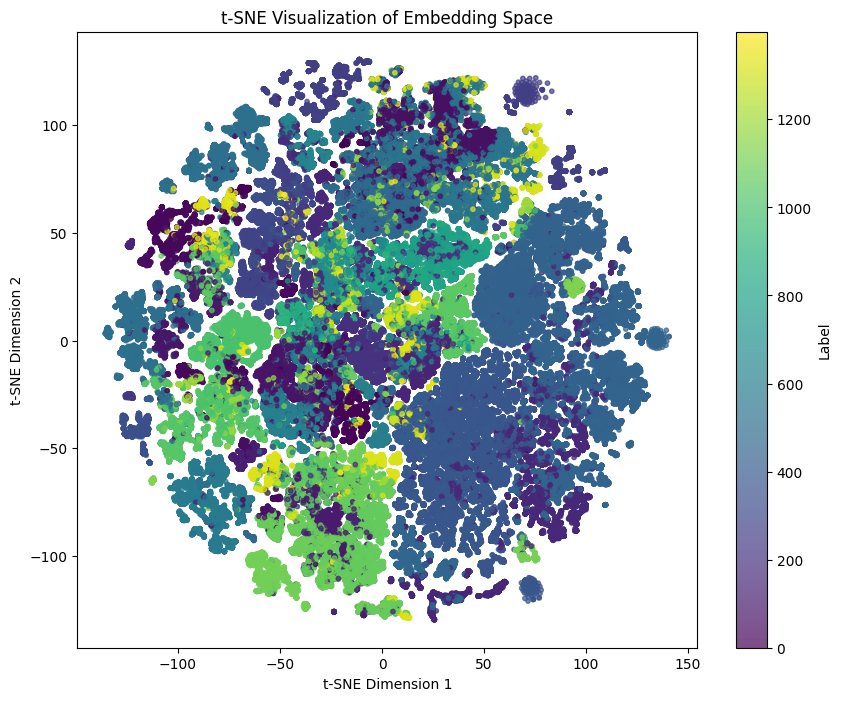

In [16]:
from sklearn.manifold import TSNE

# Reduce to 2D for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_pca)

# Plot t-SNE result
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_binarized.argmax(axis=1), cmap='viridis', s=10, alpha=0.7)
plt.colorbar(scatter, label='Label')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Embedding Space')
plt.show()


Labels less than 1%

In [ ]:
# Identify indices of labels less than 1%
less_count_indices = np.where(label_counts < 0.01*len(label_counts))[0]

# Get label names with zero count
less_count_labels = mlb.classes_[less_count_indices]

print(f"Number of labels less than 1%: {len(less_count_labels)}")
print("Labels:")
for label in less_count_labels:
    print(label)

Data Normalization

In [2]:
# Apply PCA for dimensionality reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_train_1, X_val_1, y_train, y_val = train_test_split(X, y_binarized, test_size=0.1, random_state=42)

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train_1)
#X_train = pca.fit_transform(X_train)
X_val = scalar.transform(X_val_1)
#X_val = pca.fit_transform(X_val)

Convert to Tensor dataset

In [3]:

import torch

if not isinstance(X_train, torch.Tensor):
    X_train = torch.tensor(X_train)
if not isinstance(y_train, torch.Tensor):
    y_train = torch.tensor(y_train)

In [4]:
if not isinstance(X_val, torch.Tensor):
    X_val = torch.tensor(X_val)
if not isinstance(y_val, torch.Tensor):
    y_val = torch.tensor(y_val)

**Initial MLP Classifier**

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torch.utils.data import WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Assuming you have X_train, X_val, y_train, y_val already prepared as tensors
batch_size = 64
num_classes = y_train.shape[1]  # Number of ICD-10 codes

# Ensure labels are float tensors for BCELoss
y_train = y_train.float()
y_val = y_val.float()

# Calculate weights for each class
label_counts = y_train.sum(dim=0)  # Sum occurrences of each label
weights_per_class = torch.where(label_counts > 0, 1.0 / label_counts, torch.tensor(1.0, device=label_counts.device))
weights_per_sample = (y_train * weights_per_class).sum(dim=1)
weights_per_sample = weights_per_sample.clip(min=1e-6)

sampler = WeightedRandomSampler(weights_per_sample, num_samples=len(weights_per_sample), replacement=True)


# DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

'''nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.4),
            nn.Dropout(0.055),'''

# Define the CNN model
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
            nn.Sigmoid()  # For multi-label output
        )
    
    def forward(self, x):
        return self.layers(x)


# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPClassifier(input_dim=X_train.shape[1], num_classes=num_classes).to(device)
criterion = nn.BCELoss()  # Binary cross-entropy for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=15):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

def evaluate_loss(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    return val_loss / len(val_loader)

# Evaluation function
def evaluate_model(model, val_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch).cpu()
            y_true.extend(y_batch.numpy())
            y_pred.extend((outputs > 0.5).int().numpy())  # Threshold at 0.5 for multi-label
            
    micro_f1 = f1_score(y_true, y_pred, average="micro")
    print(f"Micro-F1 Score: {micro_f1}")

# Train and evaluate the model
train_model(model, train_loader, criterion, optimizer, num_epochs=20)
evaluate_model(model, val_loader)

Epoch 1/20: 100%|██████████| 2799/2799 [00:36<00:00, 77.64it/s] 


Epoch 1, Loss: 0.011341307675512525


Epoch 2/20: 100%|██████████| 2799/2799 [00:23<00:00, 120.27it/s]


Epoch 2, Loss: 0.0038803112283868103


Epoch 3/20: 100%|██████████| 2799/2799 [00:20<00:00, 138.10it/s]


Epoch 3, Loss: 0.0032100929735077357


Epoch 4/20: 100%|██████████| 2799/2799 [00:22<00:00, 122.16it/s]


Epoch 4, Loss: 0.002871500878067765


Epoch 5/20: 100%|██████████| 2799/2799 [00:18<00:00, 152.88it/s]


Epoch 5, Loss: 0.0026484297130292826


Epoch 6/20: 100%|██████████| 2799/2799 [00:17<00:00, 160.60it/s]


Epoch 6, Loss: 0.002488880914305884


Epoch 7/20: 100%|██████████| 2799/2799 [00:18<00:00, 152.09it/s]


Epoch 7, Loss: 0.0023698915350864793


Epoch 8/20: 100%|██████████| 2799/2799 [00:17<00:00, 159.61it/s]


Epoch 8, Loss: 0.00228131417474214


Epoch 9/20: 100%|██████████| 2799/2799 [00:17<00:00, 160.19it/s]


Epoch 9, Loss: 0.0022019065138606055


Epoch 10/20: 100%|██████████| 2799/2799 [00:17<00:00, 161.33it/s]


Epoch 10, Loss: 0.0021213120201096156


Epoch 11/20: 100%|██████████| 2799/2799 [00:18<00:00, 152.37it/s]


Epoch 11, Loss: 0.002070720397699897


Epoch 12/20: 100%|██████████| 2799/2799 [00:21<00:00, 133.07it/s]


Epoch 12, Loss: 0.0020130857171540032


Epoch 13/20: 100%|██████████| 2799/2799 [00:19<00:00, 143.92it/s]


Epoch 13, Loss: 0.001979090695245449


Epoch 14/20: 100%|██████████| 2799/2799 [00:17<00:00, 160.29it/s]


Epoch 14, Loss: 0.0019325588768425957


Epoch 15/20: 100%|██████████| 2799/2799 [00:17<00:00, 160.81it/s]


Epoch 15, Loss: 0.0018909775423070348


Epoch 16/20: 100%|██████████| 2799/2799 [00:17<00:00, 163.93it/s]


Epoch 16, Loss: 0.0018752002456606767


Epoch 17/20: 100%|██████████| 2799/2799 [00:16<00:00, 165.59it/s]


Epoch 17, Loss: 0.00183409309533244


Epoch 18/20: 100%|██████████| 2799/2799 [00:17<00:00, 161.91it/s]


Epoch 18, Loss: 0.0018052331715700438


Epoch 19/20: 100%|██████████| 2799/2799 [00:17<00:00, 161.62it/s]


Epoch 19, Loss: 0.0017807347477151187


Epoch 20/20: 100%|██████████| 2799/2799 [00:16<00:00, 167.48it/s]


Epoch 20, Loss: 0.0017603552955488576
Micro-F1 Score: 0.7912765932201379


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
def evaluate_model(model, val_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch).cpu()
            y_true.extend(y_batch.numpy())
            y_pred.extend((outputs > 0.5).int().numpy())  # Threshold at 0.5 for multi-label
    acc = accuracy_score(y_true, y_pred)  
    pre = precision_score(y_true, y_pred, average="micro")  
    rec = recall_score(y_true, y_pred , average="micro")        
    micro_f1 = f1_score(y_true, y_pred, average="micro")
    print(f"Micro-F1 Score: {micro_f1}")
    print(f"Accuracy: {acc}")
    print(f"Precision: {pre}")
    print(f"Recall: {rec}")

print('Train')
evaluate_model(model, train_loader)
print('Validation')
evaluate_model(model, val_loader)

Train
Micro-F1 Score: 0.9237906233726021
Accuracy: 0.7245132145429772
Precision: 0.9264777291360041
Recall: 0.9211190596037148
Validation
Micro-F1 Score: 0.7912765932201379
Accuracy: 0.5267601387004373
Precision: 0.7900672921997914
Recall: 0.7924896019013666


In [ ]:
evaluate_model(model, train_loader)

Micro-F1 Score: 0.9113266966164684


**Final MLP Classifier**

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torch.utils.data import WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Assuming you have X_train, X_val, y_train, y_val already prepared as tensors
batch_size = 64
num_classes = y_train.shape[1]  # Number of ICD-10 codes

# Ensure labels are float tensors for BCELoss
y_train = y_train.float()
y_val = y_val.float()

# Calculate weights for each class
label_counts = y_train.sum(dim=0)  # Sum occurrences of each label
weights_per_class = torch.where(label_counts > 0, 1.0 / label_counts, torch.tensor(1.0, device=label_counts.device))
weights_per_sample = (y_train * weights_per_class).sum(dim=1)
weights_per_sample = weights_per_sample.clip(min=1e-6)

sampler = WeightedRandomSampler(weights_per_sample, num_samples=len(weights_per_sample), replacement=True)


# DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

'''nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.4),
            nn.Dropout(0.055),'''

# Define the CNN model
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(negative_slope=0.3),
            nn.Dropout(0.1),
            #nn.Linear(1024, 512),
            #nn.BatchNorm1d(512),
            #nn.LeakyReLU(negative_slope=0.3),
            #nn.Dropout(0.4),
            nn.Linear(1024, num_classes),
            nn.Sigmoid()  # For multi-label output
        )
    
    def forward(self, x):
        return self.layers(x)


# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = MLPClassifier(input_dim=X_train.shape[1], num_classes=num_classes).to(device)
criterion = nn.BCELoss()  # Binary cross-entropy for multi-label classification
optimizer = optim.Adam(model1.parameters(), lr=0.00005, weight_decay=0.22*1e-6)

# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=15):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        #val_loss = evaluate_loss(model, val_loader, criterion)
        #scheduler.step(val_loss)
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

def evaluate_loss(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    return val_loss / len(val_loader)

# Evaluation function
def evaluate_model(model, val_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch).cpu()
            y_true.extend(y_batch.numpy())
            y_pred.extend((outputs > 0.5).int().numpy())  # Threshold at 0.5 for multi-label
            
    micro_f1 = f1_score(y_true, y_pred, average="micro")
    print(f"Micro-F1 Score: {micro_f1}")

# Train and evaluate the model
train_model(model1, train_loader, criterion, optimizer, num_epochs=28)
evaluate_model(model1, val_loader)

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/28: 100%|██████████| 2799/2799 [00:25<00:00, 108.92it/s]


Epoch 1, Loss: 0.041618458350715086


Epoch 2/28: 100%|██████████| 2799/2799 [00:17<00:00, 163.64it/s]


Epoch 2, Loss: 0.005005379620604763


Epoch 3/28: 100%|██████████| 2799/2799 [00:16<00:00, 172.59it/s]


Epoch 3, Loss: 0.002724538017911141


Epoch 4/28: 100%|██████████| 2799/2799 [00:15<00:00, 179.92it/s]


Epoch 4, Loss: 0.0019697834545528174


Epoch 5/28: 100%|██████████| 2799/2799 [00:13<00:00, 201.93it/s]


Epoch 5, Loss: 0.0016259262920981163


Epoch 6/28: 100%|██████████| 2799/2799 [00:15<00:00, 178.09it/s]


Epoch 6, Loss: 0.0014184928293823704


Epoch 7/28: 100%|██████████| 2799/2799 [00:16<00:00, 168.89it/s]


Epoch 7, Loss: 0.0012775791985769373


Epoch 8/28: 100%|██████████| 2799/2799 [00:14<00:00, 192.92it/s]


Epoch 8, Loss: 0.0011663328759612135


Epoch 9/28: 100%|██████████| 2799/2799 [00:14<00:00, 187.47it/s]


Epoch 9, Loss: 0.0010845407749134907


Epoch 10/28: 100%|██████████| 2799/2799 [00:14<00:00, 192.37it/s]


Epoch 10, Loss: 0.0010213257869309271


Epoch 11/28: 100%|██████████| 2799/2799 [00:18<00:00, 155.28it/s]


Epoch 11, Loss: 0.0009640167775303864


Epoch 12/28: 100%|██████████| 2799/2799 [00:15<00:00, 185.72it/s]


Epoch 12, Loss: 0.0009228672510268025


Epoch 13/28: 100%|██████████| 2799/2799 [00:12<00:00, 223.33it/s]


Epoch 13, Loss: 0.0008798499942620602


Epoch 14/28: 100%|██████████| 2799/2799 [00:11<00:00, 234.13it/s]


Epoch 14, Loss: 0.0008467060096774692


Epoch 15/28: 100%|██████████| 2799/2799 [00:12<00:00, 229.20it/s]


Epoch 15, Loss: 0.0008127076859762623


Epoch 16/28: 100%|██████████| 2799/2799 [00:12<00:00, 226.17it/s]


Epoch 16, Loss: 0.0007825303153461294


Epoch 17/28: 100%|██████████| 2799/2799 [00:16<00:00, 166.65it/s]


Epoch 17, Loss: 0.0007618395587936491


Epoch 18/28: 100%|██████████| 2799/2799 [00:16<00:00, 166.01it/s]


Epoch 18, Loss: 0.0007429338244279755


Epoch 19/28: 100%|██████████| 2799/2799 [00:16<00:00, 167.37it/s]


Epoch 19, Loss: 0.0007262411280384599


Epoch 20/28: 100%|██████████| 2799/2799 [00:15<00:00, 176.04it/s]


Epoch 20, Loss: 0.0006988755749408275


Epoch 21/28: 100%|██████████| 2799/2799 [00:17<00:00, 155.64it/s]


Epoch 21, Loss: 0.0006871961288893793


Epoch 22/28: 100%|██████████| 2799/2799 [00:18<00:00, 152.02it/s]


Epoch 22, Loss: 0.0006728925588610607


Epoch 23/28: 100%|██████████| 2799/2799 [00:16<00:00, 170.25it/s]


Epoch 23, Loss: 0.0006577898272097399


Epoch 24/28: 100%|██████████| 2799/2799 [00:17<00:00, 160.20it/s]


Epoch 24, Loss: 0.0006480494497013493


Epoch 25/28: 100%|██████████| 2799/2799 [00:17<00:00, 161.26it/s]


Epoch 25, Loss: 0.0006310047758494448


Epoch 26/28: 100%|██████████| 2799/2799 [00:20<00:00, 134.70it/s]


Epoch 26, Loss: 0.0006239235314913061


Epoch 27/28: 100%|██████████| 2799/2799 [00:22<00:00, 122.77it/s]


Epoch 27, Loss: 0.0006120565666735776


Epoch 28/28: 100%|██████████| 2799/2799 [00:25<00:00, 108.95it/s]


Epoch 28, Loss: 0.0006070254878010388
Micro-F1 Score: 0.819047619047619


In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
def evaluate_model(model, val_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch).cpu()
            y_true.extend(y_batch.numpy())
            y_pred.extend((outputs > 0.5).int().numpy())  # Threshold at 0.5 for multi-label
    acc = accuracy_score(y_true, y_pred)  
    pre = precision_score(y_true, y_pred, average="micro")  
    rec = recall_score(y_true, y_pred , average="micro")        
    micro_f1 = f1_score(y_true, y_pred, average="micro")
    print(f"Micro-F1 Score: {micro_f1}")
    print(f"Accuracy: {acc}")
    print(f"Precision: {pre}")
    print(f"Recall: {rec}")

print('Train')
evaluate_model(model1, train_loader)
print('Validation')
evaluate_model(model1, val_loader)

Train
Micro-F1 Score: 0.9637826545208161
Accuracy: 0.85317981047894
Precision: 0.9707271207293008
Recall: 0.9569368423216431
Validation
Micro-F1 Score: 0.819047619047619
Accuracy: 0.57671239760792
Precision: 0.8387892376681614
Recall: 0.8002139037433155


In [ ]:
import torch
import torch.nn as nn

X_test = np.load('data/test_data.npy')
X_test = scalar.transform(X_test)
if not isinstance(X_test, torch.Tensor):
    X_test = torch.tensor(X_test)

test_dataset = TensorDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def get_predictions(model, test_loader, threshold=0.48):
    model.eval()
    all_predictions = []
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch[0].to(device)
            outputs = model(X_batch).cpu()
            predictions = (outputs > threshold).int().numpy()  # Thresholding at 0.5
            all_predictions.extend(predictions)
            
    return all_predictions

# Get predictions for the test set
test_predictions = get_predictions(model1, test_loader)
test_predictions1 = np.array(test_predictions)

print(test_predictions1.shape)


In [ ]:
# Combine the predictions for all labels
#y_test_pred_combined = np.vstack(test_predictions1).T
y_test_labels = mlb.inverse_transform(test_predictions1)

# Prepare submission file
submission_df = pd.DataFrame({
    'id': range(1,len(y_test_labels)+1),
    'labels': [';'.join(codes) for codes in y_test_labels]
})
submission_df.to_csv('submission21.csv', index=False)

In [ ]:
import pandas as pd

# Load the CSV files
file2 = pd.read_csv('filled_file20.csv') #hieghest scored preveous result
file1 = pd.read_csv('submission21.csv')

# Fill empty values in file1 with corresponding values from file2
filled_file = file1.combine_first(file2)

# Save the resulting dataframe to a new CSV file
filled_file.to_csv('filled_file21.csv', index=False)

print("Filled CSV file created successfully!")


**Ensemble of different MLP Classifiers trained on different sizes of dataset**

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, Subset, TensorDataset
from tqdm import tqdm
import numpy as np

# Define the MLPClassifier
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(0.05),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(negative_slope=0.3),
            nn.Dropout(0.02),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

# Define model training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=15):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        val_loss = evaluate_loss(model, val_loader, criterion)
        scheduler.step(val_loss)
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

# Generate bootstrapped datasets
def get_bootstrapped_dataloader(X_train, y_train, batch_size, n_models):
    datasets = []
    for _ in range(n_models):
        # Calculate weights for each class
        '''label_counts = y_train.sum(dim=0)  # Sum occurrences of each label
        weights_per_class = torch.where(label_counts > 0, 1.0 / label_counts, torch.tensor(1.0, device=label_counts.device))
        weights_per_sample = (y_train * weights_per_class).sum(dim=1)
        weights_per_sample = weights_per_sample.clip(min=1e-6)

        sampler = WeightedRandomSampler(weights_per_sample, num_samples=len(weights_per_sample), replacement=True)
        '''
        indices = np.random.choice(len(X_train), 4*len(X_train)//5, replace=False)
        subset = Subset(TensorDataset(X_train, y_train), indices)
        loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
        datasets.append(loader)
    return datasets

def evaluate_loss(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    return val_loss / len(val_loader)

# Evaluation function for the ensemble
def evaluate_ensemble(models, val_loader):
    y_true = []
    y_pred_ensemble = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            outputs = [model(X_batch).cpu().numpy() for model in models]
            y_true.extend(y_batch.numpy())
            avg_outputs = sum(outputs) / len(models)
            y_pred_ensemble.extend((avg_outputs > 0.5).astype(int))
            

    micro_f1 = f1_score(y_true, y_pred_ensemble, average="micro")
    print(f"Ensemble Micro-F1 Score: {micro_f1}")

# Main Training Loop
n_models = 10  # Number of models in the ensemble
bagged_loaders = get_bootstrapped_dataloader(X_train, y_train, batch_size=64, n_models=n_models)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = []
criterion = nn.BCELoss()
for i in range(n_models):
    model = MLPClassifier(input_dim=X_train.shape[1], num_classes=num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.00009)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    print(f"Training model {i + 1}")
    train_model(model, bagged_loaders[i], criterion, optimizer, num_epochs=23)
    models.append(model)

# Validate the ensemble
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)
evaluate_ensemble(models, val_loader)


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training model 1


Epoch 1/23: 100%|██████████| 2485/2485 [00:47<00:00, 52.78it/s] 


Epoch 1, Loss: 0.04173296747627992


Epoch 2/23: 100%|██████████| 2485/2485 [00:09<00:00, 262.97it/s]


Epoch 2, Loss: 0.0027997612929293956


Epoch 3/23: 100%|██████████| 2485/2485 [00:09<00:00, 263.79it/s]


Epoch 3, Loss: 0.0017527459381603573


Epoch 4/23: 100%|██████████| 2485/2485 [00:09<00:00, 259.80it/s]


Epoch 4, Loss: 0.0014906290391557503


Epoch 5/23: 100%|██████████| 2485/2485 [00:09<00:00, 266.08it/s]


Epoch 5, Loss: 0.001353768335062246


Epoch 6/23: 100%|██████████| 2485/2485 [00:09<00:00, 264.70it/s]


Epoch 6, Loss: 0.0012582571152035499


Epoch 7/23: 100%|██████████| 2485/2485 [00:09<00:00, 267.81it/s]


Epoch 7, Loss: 0.0011835435569573052


Epoch 8/23: 100%|██████████| 2485/2485 [00:09<00:00, 267.71it/s]


Epoch 8, Loss: 0.0011213663037186134


Epoch 9/23: 100%|██████████| 2485/2485 [00:09<00:00, 264.26it/s]


Epoch 9, Loss: 0.0010636480561208347


Epoch 10/23: 100%|██████████| 2485/2485 [00:09<00:00, 266.99it/s]


Epoch 10, Loss: 0.0010141970522062743


Epoch 11/23: 100%|██████████| 2485/2485 [00:09<00:00, 267.54it/s]


Epoch 11, Loss: 0.0009667373362130352


Epoch 12/23: 100%|██████████| 2485/2485 [00:09<00:00, 266.03it/s]


Epoch 12, Loss: 0.0009229408062467918


Epoch 13/23: 100%|██████████| 2485/2485 [00:09<00:00, 266.24it/s]


Epoch 13, Loss: 0.0008822249378507743


Epoch 14/23: 100%|██████████| 2485/2485 [00:09<00:00, 265.77it/s]


Epoch 14, Loss: 0.0008423709607485427


Epoch 15/23: 100%|██████████| 2485/2485 [00:09<00:00, 264.39it/s]


Epoch 15, Loss: 0.0008042082707823949


Epoch 16/23: 100%|██████████| 2485/2485 [00:09<00:00, 264.68it/s]


Epoch 16, Loss: 0.0006554249948255111


Epoch 17/23: 100%|██████████| 2485/2485 [00:09<00:00, 266.98it/s]


Epoch 17, Loss: 0.0006310763094251904


Epoch 18/23: 100%|██████████| 2485/2485 [00:09<00:00, 267.06it/s]


Epoch 18, Loss: 0.0006208057689946145


Epoch 19/23: 100%|██████████| 2485/2485 [00:09<00:00, 264.20it/s]


Epoch 19, Loss: 0.0006125946279865328


Epoch 20/23: 100%|██████████| 2485/2485 [00:09<00:00, 267.06it/s]


Epoch 20, Loss: 0.0006057168636752116


Epoch 21/23: 100%|██████████| 2485/2485 [00:09<00:00, 267.73it/s]


Epoch 21, Loss: 0.0005991321188956125


Epoch 22/23: 100%|██████████| 2485/2485 [00:09<00:00, 264.28it/s]


Epoch 22, Loss: 0.0005801298273999012


Epoch 23/23: 100%|██████████| 2485/2485 [00:10<00:00, 244.46it/s]


Epoch 23, Loss: 0.0005783219504654052
Training model 2


Epoch 1/23: 100%|██████████| 2485/2485 [00:11<00:00, 207.89it/s]


Epoch 1, Loss: 0.04181844532767112


Epoch 2/23: 100%|██████████| 2485/2485 [00:09<00:00, 255.67it/s]


Epoch 2, Loss: 0.0028021414920460933


Epoch 3/23: 100%|██████████| 2485/2485 [00:09<00:00, 267.99it/s]


Epoch 3, Loss: 0.0017513215726651851


Epoch 4/23: 100%|██████████| 2485/2485 [00:10<00:00, 244.05it/s]


Epoch 4, Loss: 0.0014864631328390728


Epoch 5/23: 100%|██████████| 2485/2485 [00:09<00:00, 258.74it/s]


Epoch 5, Loss: 0.0013507804009310106


Epoch 6/23: 100%|██████████| 2485/2485 [00:09<00:00, 271.04it/s]


Epoch 6, Loss: 0.0012559139247753206


Epoch 7/23: 100%|██████████| 2485/2485 [00:09<00:00, 271.42it/s]


Epoch 7, Loss: 0.0011809950085428038


Epoch 8/23: 100%|██████████| 2485/2485 [00:09<00:00, 269.92it/s]


Epoch 8, Loss: 0.0011180060582799496


Epoch 9/23: 100%|██████████| 2485/2485 [00:09<00:00, 272.10it/s]


Epoch 9, Loss: 0.0010601497432348175


Epoch 10/23: 100%|██████████| 2485/2485 [00:09<00:00, 271.77it/s]


Epoch 10, Loss: 0.0010115536337838296


Epoch 11/23: 100%|██████████| 2485/2485 [00:09<00:00, 269.87it/s]


Epoch 11, Loss: 0.0009633166648745462


Epoch 12/23: 100%|██████████| 2485/2485 [00:09<00:00, 268.66it/s]


Epoch 12, Loss: 0.0009194127038042521


Epoch 13/23: 100%|██████████| 2485/2485 [00:09<00:00, 265.56it/s]


Epoch 13, Loss: 0.0008777166194408023


Epoch 14/23: 100%|██████████| 2485/2485 [00:09<00:00, 250.31it/s]


Epoch 14, Loss: 0.0008411992864914696


Epoch 15/23: 100%|██████████| 2485/2485 [00:09<00:00, 263.28it/s]


Epoch 15, Loss: 0.0006902049871356465


Epoch 16/23: 100%|██████████| 2485/2485 [00:09<00:00, 268.22it/s]


Epoch 16, Loss: 0.0006664211813770834


Epoch 17/23: 100%|██████████| 2485/2485 [00:09<00:00, 268.48it/s]


Epoch 17, Loss: 0.0006561726189880881


Epoch 18/23: 100%|██████████| 2485/2485 [00:10<00:00, 226.41it/s]


Epoch 18, Loss: 0.0006480396428108927


Epoch 19/23: 100%|██████████| 2485/2485 [00:12<00:00, 194.42it/s]


Epoch 19, Loss: 0.0006407695632218056


Epoch 20/23: 100%|██████████| 2485/2485 [00:12<00:00, 199.11it/s]


Epoch 20, Loss: 0.0006341097058184442


Epoch 21/23: 100%|██████████| 2485/2485 [00:12<00:00, 195.11it/s]


Epoch 21, Loss: 0.0006277278556171767


Epoch 22/23: 100%|██████████| 2485/2485 [00:13<00:00, 189.34it/s]


Epoch 22, Loss: 0.0006088226970488494


Epoch 23/23: 100%|██████████| 2485/2485 [00:14<00:00, 173.81it/s]


Epoch 23, Loss: 0.0006069925311185472
Training model 3


Epoch 1/23: 100%|██████████| 2485/2485 [00:13<00:00, 179.76it/s]


Epoch 1, Loss: 0.041840762340311914


Epoch 2/23: 100%|██████████| 2485/2485 [00:12<00:00, 191.93it/s]


Epoch 2, Loss: 0.0028265931096838662


Epoch 3/23: 100%|██████████| 2485/2485 [00:15<00:00, 162.57it/s]


Epoch 3, Loss: 0.001758894055071746


Epoch 4/23: 100%|██████████| 2485/2485 [00:15<00:00, 165.56it/s]


Epoch 4, Loss: 0.00149079618431624


Epoch 5/23: 100%|██████████| 2485/2485 [00:12<00:00, 206.05it/s]


Epoch 5, Loss: 0.0013554976273269976


Epoch 6/23: 100%|██████████| 2485/2485 [00:12<00:00, 203.32it/s]


Epoch 6, Loss: 0.001260024534493415


Epoch 7/23: 100%|██████████| 2485/2485 [00:11<00:00, 211.56it/s]


Epoch 7, Loss: 0.0011845285295915436


Epoch 8/23: 100%|██████████| 2485/2485 [00:11<00:00, 208.04it/s]


Epoch 8, Loss: 0.0011220513428402109


Epoch 9/23: 100%|██████████| 2485/2485 [00:11<00:00, 210.25it/s]


Epoch 9, Loss: 0.001066500107348771


Epoch 10/23: 100%|██████████| 2485/2485 [00:11<00:00, 218.54it/s]


Epoch 10, Loss: 0.001015236378076788


Epoch 11/23: 100%|██████████| 2485/2485 [00:11<00:00, 219.63it/s]


Epoch 11, Loss: 0.0009701873087375734


Epoch 12/23: 100%|██████████| 2485/2485 [00:12<00:00, 201.02it/s]


Epoch 12, Loss: 0.0009265159548731554


Epoch 13/23: 100%|██████████| 2485/2485 [00:13<00:00, 182.84it/s]


Epoch 13, Loss: 0.0008845544452038809


Epoch 14/23: 100%|██████████| 2485/2485 [00:11<00:00, 207.93it/s]


Epoch 14, Loss: 0.000845142402435546


Epoch 15/23: 100%|██████████| 2485/2485 [00:11<00:00, 215.32it/s]


Epoch 15, Loss: 0.0008086003959731721


Epoch 16/23: 100%|██████████| 2485/2485 [00:11<00:00, 223.48it/s]


Epoch 16, Loss: 0.000772888335772702


Epoch 17/23: 100%|██████████| 2485/2485 [00:11<00:00, 221.93it/s]


Epoch 17, Loss: 0.0006252136907490604


Epoch 18/23: 100%|██████████| 2485/2485 [00:11<00:00, 221.00it/s]


Epoch 18, Loss: 0.0006009925474338721


Epoch 19/23: 100%|██████████| 2485/2485 [00:11<00:00, 219.65it/s]


Epoch 19, Loss: 0.0005909121923019334


Epoch 20/23: 100%|██████████| 2485/2485 [00:11<00:00, 218.13it/s]


Epoch 20, Loss: 0.0005833065121104825


Epoch 21/23: 100%|██████████| 2485/2485 [00:11<00:00, 216.86it/s]


Epoch 21, Loss: 0.0005639522190435773


Epoch 22/23: 100%|██████████| 2485/2485 [00:11<00:00, 220.07it/s]


Epoch 22, Loss: 0.0005620509589262404


Epoch 23/23: 100%|██████████| 2485/2485 [00:11<00:00, 218.41it/s]


Epoch 23, Loss: 0.0005610868077813245
Training model 4


Epoch 1/23: 100%|██████████| 2485/2485 [00:13<00:00, 180.75it/s]


Epoch 1, Loss: 0.0417072298799752


Epoch 2/23: 100%|██████████| 2485/2485 [00:11<00:00, 217.59it/s]


Epoch 2, Loss: 0.0028171759001326033


Epoch 3/23: 100%|██████████| 2485/2485 [00:11<00:00, 219.58it/s]


Epoch 3, Loss: 0.001759954487016683


Epoch 4/23: 100%|██████████| 2485/2485 [00:11<00:00, 221.45it/s]


Epoch 4, Loss: 0.0014947751973112915


Epoch 5/23: 100%|██████████| 2485/2485 [00:11<00:00, 220.31it/s]


Epoch 5, Loss: 0.001356440310397371


Epoch 6/23: 100%|██████████| 2485/2485 [00:11<00:00, 223.76it/s]


Epoch 6, Loss: 0.0012613011956012525


Epoch 7/23: 100%|██████████| 2485/2485 [00:11<00:00, 220.79it/s]


Epoch 7, Loss: 0.0011854068710144526


Epoch 8/23: 100%|██████████| 2485/2485 [00:13<00:00, 184.17it/s]


Epoch 8, Loss: 0.0011236274851508573


Epoch 9/23: 100%|██████████| 2485/2485 [00:11<00:00, 208.56it/s]


Epoch 9, Loss: 0.0010678933038595518


Epoch 10/23: 100%|██████████| 2485/2485 [00:12<00:00, 201.24it/s]


Epoch 10, Loss: 0.00101637827376301


Epoch 11/23: 100%|██████████| 2485/2485 [00:12<00:00, 196.37it/s]


Epoch 11, Loss: 0.0009703271850260533


Epoch 12/23: 100%|██████████| 2485/2485 [00:12<00:00, 201.13it/s]


Epoch 12, Loss: 0.0009262349959921984


Epoch 13/23: 100%|██████████| 2485/2485 [00:13<00:00, 185.85it/s]


Epoch 13, Loss: 0.0008854765201622706


Epoch 14/23: 100%|██████████| 2485/2485 [00:12<00:00, 202.40it/s]


Epoch 14, Loss: 0.000734057810527162


Epoch 15/23: 100%|██████████| 2485/2485 [00:12<00:00, 202.68it/s]


Epoch 15, Loss: 0.0007102978626014084


Epoch 16/23: 100%|██████████| 2485/2485 [00:11<00:00, 212.81it/s]


Epoch 16, Loss: 0.0006998056604529748


Epoch 17/23: 100%|██████████| 2485/2485 [00:11<00:00, 215.49it/s]


Epoch 17, Loss: 0.0006915428433042597


Epoch 18/23: 100%|██████████| 2485/2485 [00:11<00:00, 214.54it/s]


Epoch 18, Loss: 0.0006841844939172335


Epoch 19/23: 100%|██████████| 2485/2485 [00:11<00:00, 217.30it/s]


Epoch 19, Loss: 0.0006772004118609904


Epoch 20/23: 100%|██████████| 2485/2485 [00:11<00:00, 217.29it/s]


Epoch 20, Loss: 0.00067079804101734


Epoch 21/23: 100%|██████████| 2485/2485 [00:11<00:00, 220.76it/s]


Epoch 21, Loss: 0.0006645503425567787


Epoch 22/23: 100%|██████████| 2485/2485 [00:11<00:00, 219.00it/s]


Epoch 22, Loss: 0.0006582071203471421


Epoch 23/23: 100%|██████████| 2485/2485 [00:11<00:00, 219.08it/s]


Epoch 23, Loss: 0.0006394594702335595
Training model 5


Epoch 1/23: 100%|██████████| 2485/2485 [00:12<00:00, 196.40it/s]


Epoch 1, Loss: 0.04185545656425312


Epoch 2/23: 100%|██████████| 2485/2485 [00:11<00:00, 219.21it/s]


Epoch 2, Loss: 0.0027951489074785315


Epoch 3/23: 100%|██████████| 2485/2485 [00:11<00:00, 220.05it/s]


Epoch 3, Loss: 0.001750813787044129


Epoch 4/23: 100%|██████████| 2485/2485 [00:11<00:00, 220.69it/s]


Epoch 4, Loss: 0.0014907885674983114


Epoch 5/23: 100%|██████████| 2485/2485 [00:11<00:00, 222.80it/s]


Epoch 5, Loss: 0.0013539097980657963


Epoch 6/23: 100%|██████████| 2485/2485 [00:11<00:00, 221.05it/s]


Epoch 6, Loss: 0.0012591336420933964


Epoch 7/23: 100%|██████████| 2485/2485 [00:11<00:00, 222.28it/s]


Epoch 7, Loss: 0.0011845133437398425


Epoch 8/23: 100%|██████████| 2485/2485 [00:11<00:00, 221.41it/s]


Epoch 8, Loss: 0.0011209533417033373


Epoch 9/23: 100%|██████████| 2485/2485 [00:11<00:00, 219.80it/s]


Epoch 9, Loss: 0.0010646332194466496


Epoch 10/23: 100%|██████████| 2485/2485 [00:11<00:00, 221.07it/s]


Epoch 10, Loss: 0.0010137618981279298


Epoch 11/23: 100%|██████████| 2485/2485 [00:11<00:00, 219.98it/s]


Epoch 11, Loss: 0.0009670591824153959


Epoch 12/23: 100%|██████████| 2485/2485 [00:11<00:00, 218.14it/s]


Epoch 12, Loss: 0.0008123943010289822


Epoch 13/23: 100%|██████████| 2485/2485 [00:12<00:00, 205.12it/s]


Epoch 13, Loss: 0.0007886917409027966


Epoch 14/23: 100%|██████████| 2485/2485 [00:13<00:00, 188.21it/s]


Epoch 14, Loss: 0.0007781580254839362


Epoch 15/23: 100%|██████████| 2485/2485 [00:11<00:00, 224.88it/s]


Epoch 15, Loss: 0.0007695052716777973


Epoch 16/23: 100%|██████████| 2485/2485 [00:12<00:00, 202.58it/s]


Epoch 16, Loss: 0.0007616267069917495


Epoch 17/23: 100%|██████████| 2485/2485 [00:11<00:00, 218.07it/s]


Epoch 17, Loss: 0.0007546824853425991


Epoch 18/23: 100%|██████████| 2485/2485 [00:12<00:00, 201.94it/s]


Epoch 18, Loss: 0.0007347723498417653


Epoch 19/23: 100%|██████████| 2485/2485 [00:11<00:00, 215.09it/s]


Epoch 19, Loss: 0.0007327489601963498


Epoch 20/23: 100%|██████████| 2485/2485 [00:11<00:00, 215.95it/s]


Epoch 20, Loss: 0.0007317228518567897


Epoch 21/23: 100%|██████████| 2485/2485 [00:15<00:00, 164.32it/s]


Epoch 21, Loss: 0.0007308966435105081


Epoch 22/23: 100%|██████████| 2485/2485 [00:14<00:00, 167.03it/s]


Epoch 22, Loss: 0.0007283956119303462


Epoch 23/23: 100%|██████████| 2485/2485 [00:14<00:00, 171.19it/s]


Epoch 23, Loss: 0.0007283160137972969
Training model 6


Epoch 1/23: 100%|██████████| 2485/2485 [00:17<00:00, 142.60it/s]


Epoch 1, Loss: 0.04184631365435704


Epoch 2/23: 100%|██████████| 2485/2485 [00:17<00:00, 144.24it/s]


Epoch 2, Loss: 0.002807829942801589


Epoch 3/23: 100%|██████████| 2485/2485 [00:15<00:00, 156.29it/s]


Epoch 3, Loss: 0.0017519365835436424


Epoch 4/23: 100%|██████████| 2485/2485 [00:16<00:00, 148.69it/s]


Epoch 4, Loss: 0.0014901039385943255


Epoch 5/23: 100%|██████████| 2485/2485 [00:15<00:00, 156.51it/s]


Epoch 5, Loss: 0.001351565894997778


Epoch 6/23: 100%|██████████| 2485/2485 [00:16<00:00, 154.89it/s]


Epoch 6, Loss: 0.0012560125997606703


Epoch 7/23: 100%|██████████| 2485/2485 [00:15<00:00, 155.79it/s]


Epoch 7, Loss: 0.0011826269625605532


Epoch 8/23: 100%|██████████| 2485/2485 [00:15<00:00, 155.40it/s]


Epoch 8, Loss: 0.0011187104385072587


Epoch 9/23: 100%|██████████| 2485/2485 [00:15<00:00, 156.09it/s]


Epoch 9, Loss: 0.0010621995300193218


Epoch 10/23: 100%|██████████| 2485/2485 [00:15<00:00, 156.06it/s]


Epoch 10, Loss: 0.0010122558634430244


Epoch 11/23: 100%|██████████| 2485/2485 [00:16<00:00, 154.87it/s]


Epoch 11, Loss: 0.000964271846476575


Epoch 12/23: 100%|██████████| 2485/2485 [00:15<00:00, 156.75it/s]


Epoch 12, Loss: 0.00092144316737868


Epoch 13/23: 100%|██████████| 2485/2485 [00:16<00:00, 154.96it/s]


Epoch 13, Loss: 0.0007681902318113526


Epoch 14/23: 100%|██████████| 2485/2485 [00:16<00:00, 155.15it/s]


Epoch 14, Loss: 0.0007450908000845185


Epoch 15/23: 100%|██████████| 2485/2485 [00:15<00:00, 156.73it/s]


Epoch 15, Loss: 0.0007346185747350395


Epoch 16/23: 100%|██████████| 2485/2485 [00:16<00:00, 148.56it/s]


Epoch 16, Loss: 0.0007259532622805603


Epoch 17/23: 100%|██████████| 2485/2485 [00:15<00:00, 155.95it/s]


Epoch 17, Loss: 0.0007182459029033162


Epoch 18/23: 100%|██████████| 2485/2485 [00:16<00:00, 154.19it/s]


Epoch 18, Loss: 0.0007115802890433737


Epoch 19/23: 100%|██████████| 2485/2485 [00:16<00:00, 146.23it/s]


Epoch 19, Loss: 0.0007045276131002154


Epoch 20/23: 100%|██████████| 2485/2485 [00:16<00:00, 149.48it/s]


Epoch 20, Loss: 0.0006983301399806908


Epoch 21/23: 100%|██████████| 2485/2485 [00:16<00:00, 153.60it/s]


Epoch 21, Loss: 0.0006920323559945971


Epoch 22/23: 100%|██████████| 2485/2485 [00:16<00:00, 153.78it/s]


Epoch 22, Loss: 0.0006726498378513819


Epoch 23/23: 100%|██████████| 2485/2485 [00:15<00:00, 155.38it/s]


Epoch 23, Loss: 0.0006707302550574431
Training model 7


Epoch 1/23: 100%|██████████| 2485/2485 [00:18<00:00, 131.02it/s]


Epoch 1, Loss: 0.041499203980208885


Epoch 2/23: 100%|██████████| 2485/2485 [00:16<00:00, 153.73it/s]


Epoch 2, Loss: 0.002807856719871567


Epoch 3/23: 100%|██████████| 2485/2485 [00:16<00:00, 154.91it/s]


Epoch 3, Loss: 0.0017573143846507163


Epoch 4/23: 100%|██████████| 2485/2485 [00:15<00:00, 155.36it/s]


Epoch 4, Loss: 0.001488952896060231


Epoch 5/23: 100%|██████████| 2485/2485 [00:15<00:00, 155.92it/s]


Epoch 5, Loss: 0.001352719146541884


Epoch 6/23: 100%|██████████| 2485/2485 [00:16<00:00, 152.66it/s]


Epoch 6, Loss: 0.0012569764907747298


Epoch 7/23: 100%|██████████| 2485/2485 [00:16<00:00, 147.68it/s]


Epoch 7, Loss: 0.0011824816967814155


Epoch 8/23: 100%|██████████| 2485/2485 [00:16<00:00, 149.64it/s]


Epoch 8, Loss: 0.0011207521231601416


Epoch 9/23: 100%|██████████| 2485/2485 [00:18<00:00, 135.69it/s]


Epoch 9, Loss: 0.0010641951762538936


Epoch 10/23: 100%|██████████| 2485/2485 [00:22<00:00, 112.25it/s]


Epoch 10, Loss: 0.0010130360288033917


Epoch 11/23: 100%|██████████| 2485/2485 [00:13<00:00, 184.20it/s]


Epoch 11, Loss: 0.0009669155096054317


Epoch 12/23: 100%|██████████| 2485/2485 [00:12<00:00, 196.95it/s]


Epoch 12, Loss: 0.0009229927608355415


Epoch 13/23: 100%|██████████| 2485/2485 [00:12<00:00, 192.00it/s]


Epoch 13, Loss: 0.0008819040117979282


Epoch 14/23: 100%|██████████| 2485/2485 [00:13<00:00, 190.96it/s]


Epoch 14, Loss: 0.0008430435348693769


Epoch 15/23: 100%|██████████| 2485/2485 [00:12<00:00, 198.29it/s]


Epoch 15, Loss: 0.0008043905294156433


Epoch 16/23: 100%|██████████| 2485/2485 [00:12<00:00, 201.10it/s]


Epoch 16, Loss: 0.0007692678958122287


Epoch 17/23: 100%|██████████| 2485/2485 [00:12<00:00, 203.28it/s]


Epoch 17, Loss: 0.0006222325117281362


Epoch 18/23: 100%|██████████| 2485/2485 [00:12<00:00, 201.62it/s]


Epoch 18, Loss: 0.0005981436969070102


Epoch 19/23: 100%|██████████| 2485/2485 [00:14<00:00, 169.64it/s]


Epoch 19, Loss: 0.0005879041696118633


Epoch 20/23: 100%|██████████| 2485/2485 [00:11<00:00, 222.38it/s]


Epoch 20, Loss: 0.0005799637801272484


Epoch 21/23: 100%|██████████| 2485/2485 [00:11<00:00, 210.35it/s]


Epoch 21, Loss: 0.0005731555426006545


Epoch 22/23: 100%|██████████| 2485/2485 [00:11<00:00, 212.38it/s]


Epoch 22, Loss: 0.0005543186925611622


Epoch 23/23: 100%|██████████| 2485/2485 [00:11<00:00, 209.06it/s]


Epoch 23, Loss: 0.0005523482989707223
Training model 8


Epoch 1/23: 100%|██████████| 2485/2485 [00:15<00:00, 163.53it/s]


Epoch 1, Loss: 0.04185243840919624


Epoch 2/23: 100%|██████████| 2485/2485 [00:12<00:00, 202.25it/s]


Epoch 2, Loss: 0.002826117843312682


Epoch 3/23: 100%|██████████| 2485/2485 [00:11<00:00, 208.93it/s]


Epoch 3, Loss: 0.0017590315018638115


Epoch 4/23: 100%|██████████| 2485/2485 [00:11<00:00, 212.78it/s]


Epoch 4, Loss: 0.0014907555061793498


Epoch 5/23: 100%|██████████| 2485/2485 [00:11<00:00, 208.85it/s]


Epoch 5, Loss: 0.0013509526894469061


Epoch 6/23: 100%|██████████| 2485/2485 [00:11<00:00, 210.19it/s]


Epoch 6, Loss: 0.0012553383540961764


Epoch 7/23: 100%|██████████| 2485/2485 [00:12<00:00, 202.97it/s]


Epoch 7, Loss: 0.001180136048022313


Epoch 8/23: 100%|██████████| 2485/2485 [00:11<00:00, 209.93it/s]


Epoch 8, Loss: 0.001117614079294895


Epoch 9/23: 100%|██████████| 2485/2485 [00:11<00:00, 213.33it/s]


Epoch 9, Loss: 0.0010609870216709897


Epoch 10/23: 100%|██████████| 2485/2485 [00:11<00:00, 213.20it/s]


Epoch 10, Loss: 0.0010102493976106046


Epoch 11/23: 100%|██████████| 2485/2485 [00:11<00:00, 211.50it/s]


Epoch 11, Loss: 0.0009633060507719935


Epoch 12/23: 100%|██████████| 2485/2485 [00:11<00:00, 207.96it/s]


Epoch 12, Loss: 0.0009195140692484106


Epoch 13/23: 100%|██████████| 2485/2485 [00:12<00:00, 203.72it/s]


Epoch 13, Loss: 0.0008782766190319092


Epoch 14/23: 100%|██████████| 2485/2485 [00:11<00:00, 210.97it/s]


Epoch 14, Loss: 0.0007286653748312422


Epoch 15/23: 100%|██████████| 2485/2485 [00:11<00:00, 208.31it/s]


Epoch 15, Loss: 0.0007048244727447524


Epoch 16/23: 100%|██████████| 2485/2485 [00:11<00:00, 210.00it/s]


Epoch 16, Loss: 0.0006944480521339264


Epoch 17/23: 100%|██████████| 2485/2485 [00:12<00:00, 201.59it/s]


Epoch 17, Loss: 0.0006860260121567433


Epoch 18/23: 100%|██████████| 2485/2485 [00:12<00:00, 197.53it/s]


Epoch 18, Loss: 0.0006786678152222569


Epoch 19/23: 100%|██████████| 2485/2485 [00:11<00:00, 210.04it/s]


Epoch 19, Loss: 0.0006720295196522769


Epoch 20/23: 100%|██████████| 2485/2485 [00:11<00:00, 208.82it/s]


Epoch 20, Loss: 0.0006525475265958554


Epoch 21/23: 100%|██████████| 2485/2485 [00:11<00:00, 207.69it/s]


Epoch 21, Loss: 0.0006506372998108792


Epoch 22/23: 100%|██████████| 2485/2485 [00:12<00:00, 202.43it/s]


Epoch 22, Loss: 0.0006496900151496832


Epoch 23/23: 100%|██████████| 2485/2485 [00:12<00:00, 204.61it/s]


Epoch 23, Loss: 0.0006489120325180412
Training model 9


Epoch 1/23: 100%|██████████| 2485/2485 [00:13<00:00, 182.39it/s]


Epoch 1, Loss: 0.04192552257805193


Epoch 2/23: 100%|██████████| 2485/2485 [00:11<00:00, 209.34it/s]


Epoch 2, Loss: 0.0028206569935294466


Epoch 3/23: 100%|██████████| 2485/2485 [00:11<00:00, 209.09it/s]


Epoch 3, Loss: 0.0017580927288022934


Epoch 4/23: 100%|██████████| 2485/2485 [00:11<00:00, 207.54it/s]


Epoch 4, Loss: 0.0014914959967295663


Epoch 5/23: 100%|██████████| 2485/2485 [00:11<00:00, 207.24it/s]


Epoch 5, Loss: 0.001354839263804317


Epoch 6/23: 100%|██████████| 2485/2485 [00:12<00:00, 203.99it/s]


Epoch 6, Loss: 0.001261008059455108


Epoch 7/23: 100%|██████████| 2485/2485 [00:13<00:00, 187.62it/s]


Epoch 7, Loss: 0.0011855069505026419


Epoch 8/23: 100%|██████████| 2485/2485 [00:13<00:00, 184.96it/s]


Epoch 8, Loss: 0.00112342458615132


Epoch 9/23: 100%|██████████| 2485/2485 [00:13<00:00, 184.81it/s]


Epoch 9, Loss: 0.0010673569790340615


Epoch 10/23: 100%|██████████| 2485/2485 [00:13<00:00, 179.88it/s]


Epoch 10, Loss: 0.0010161920389492192


Epoch 11/23: 100%|██████████| 2485/2485 [00:13<00:00, 184.41it/s]


Epoch 11, Loss: 0.0009694755257606709


Epoch 12/23: 100%|██████████| 2485/2485 [00:13<00:00, 187.87it/s]


Epoch 12, Loss: 0.0009263295549932133


Epoch 13/23: 100%|██████████| 2485/2485 [00:13<00:00, 186.54it/s]


Epoch 13, Loss: 0.0008857364088889039


Epoch 14/23: 100%|██████████| 2485/2485 [00:13<00:00, 186.81it/s]


Epoch 14, Loss: 0.0008452635310436608


Epoch 15/23: 100%|██████████| 2485/2485 [00:13<00:00, 184.05it/s]


Epoch 15, Loss: 0.0008089827984511492


Epoch 16/23: 100%|██████████| 2485/2485 [00:13<00:00, 179.30it/s]


Epoch 16, Loss: 0.0006622649644107053


Epoch 17/23: 100%|██████████| 2485/2485 [00:13<00:00, 182.00it/s]


Epoch 17, Loss: 0.0006376718402131867


Epoch 18/23: 100%|██████████| 2485/2485 [00:13<00:00, 185.23it/s]


Epoch 18, Loss: 0.0006274228444874804


Epoch 19/23: 100%|██████████| 2485/2485 [00:13<00:00, 179.62it/s]


Epoch 19, Loss: 0.0006195256928655635


Epoch 20/23: 100%|██████████| 2485/2485 [00:13<00:00, 184.39it/s]


Epoch 20, Loss: 0.0006123638767149427


Epoch 21/23: 100%|██████████| 2485/2485 [00:13<00:00, 186.51it/s]


Epoch 21, Loss: 0.0006059001879302796


Epoch 22/23: 100%|██████████| 2485/2485 [00:13<00:00, 186.14it/s]


Epoch 22, Loss: 0.0005870114127220867


Epoch 23/23: 100%|██████████| 2485/2485 [00:13<00:00, 185.47it/s]


Epoch 23, Loss: 0.0005851436684060826
Training model 10


Epoch 1/23: 100%|██████████| 2485/2485 [00:15<00:00, 155.44it/s]


Epoch 1, Loss: 0.041693450152589163


Epoch 2/23: 100%|██████████| 2485/2485 [00:12<00:00, 195.06it/s]


Epoch 2, Loss: 0.0028004814253677754


Epoch 3/23: 100%|██████████| 2485/2485 [00:11<00:00, 210.41it/s]


Epoch 3, Loss: 0.0017522882016879737


Epoch 4/23: 100%|██████████| 2485/2485 [00:12<00:00, 196.01it/s]


Epoch 4, Loss: 0.0014863397746901561


Epoch 5/23: 100%|██████████| 2485/2485 [00:12<00:00, 205.58it/s]


Epoch 5, Loss: 0.0013488839272226035


Epoch 6/23: 100%|██████████| 2485/2485 [00:11<00:00, 209.79it/s]


Epoch 6, Loss: 0.0012550238829918423


Epoch 7/23: 100%|██████████| 2485/2485 [00:11<00:00, 210.63it/s]


Epoch 7, Loss: 0.0011805112808624234


Epoch 8/23: 100%|██████████| 2485/2485 [00:11<00:00, 207.76it/s]


Epoch 8, Loss: 0.0011166041413597553


Epoch 9/23: 100%|██████████| 2485/2485 [00:11<00:00, 209.83it/s]


Epoch 9, Loss: 0.0010606169724514637


Epoch 10/23: 100%|██████████| 2485/2485 [00:11<00:00, 207.61it/s]


Epoch 10, Loss: 0.0010107805107540304


Epoch 11/23: 100%|██████████| 2485/2485 [00:11<00:00, 210.74it/s]


Epoch 11, Loss: 0.0009638282421918237


Epoch 12/23: 100%|██████████| 2485/2485 [00:12<00:00, 205.28it/s]


Epoch 12, Loss: 0.0009190480319888029


Epoch 13/23: 100%|██████████| 2485/2485 [00:12<00:00, 206.52it/s]


Epoch 13, Loss: 0.0008792068264554901


Epoch 14/23: 100%|██████████| 2485/2485 [00:12<00:00, 205.57it/s]


Epoch 14, Loss: 0.0008406767942188438


Epoch 15/23: 100%|██████████| 2485/2485 [00:11<00:00, 207.94it/s]


Epoch 15, Loss: 0.0008032788705479886


Epoch 16/23: 100%|██████████| 2485/2485 [00:11<00:00, 210.07it/s]


Epoch 16, Loss: 0.0007683135811998406


Epoch 17/23: 100%|██████████| 2485/2485 [00:11<00:00, 208.98it/s]


Epoch 17, Loss: 0.000733922974319409


Epoch 18/23: 100%|██████████| 2485/2485 [00:11<00:00, 211.65it/s]


Epoch 18, Loss: 0.0005879483352718833


Epoch 19/23: 100%|██████████| 2485/2485 [00:16<00:00, 149.28it/s]


Epoch 19, Loss: 0.0005635944582166813


Epoch 20/23: 100%|██████████| 2485/2485 [00:14<00:00, 169.24it/s]


Epoch 20, Loss: 0.0005534749016539574


Epoch 21/23: 100%|██████████| 2485/2485 [00:12<00:00, 196.90it/s]


Epoch 21, Loss: 0.0005458771163537739


Epoch 22/23: 100%|██████████| 2485/2485 [00:11<00:00, 207.20it/s]


Epoch 22, Loss: 0.0005267900825966285


Epoch 23/23: 100%|██████████| 2485/2485 [00:11<00:00, 207.75it/s]


Epoch 23, Loss: 0.000524982532966035
Ensemble Micro-F1 Score: 0.8400954653937946


In [78]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
evaluate_ensemble(models, train_loader)

Ensemble Micro-F1 Score: 0.8990795407574664


In [62]:
test_loader = DataLoader(TensorDataset(X_test), batch_size=64, shuffle=False)

In [63]:
def predict_ensemble(models, test_loader):
    models = [model.eval() for model in models]  # Set all models to evaluation mode
    y_pred_ensemble = []

    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch[0].to(device)  # Since test data has no labels, just use X_batch
            # Collect predictions from each model in the ensemble
            outputs = [model(X_batch).cpu().numpy() for model in models]
            
            # Average predictions
            avg_outputs = sum(outputs) / len(models)
            
            # Apply threshold of 0.5 for multi-label classification
            y_pred_ensemble.extend((avg_outputs > 0.5).astype(int))
    
    return y_pred_ensemble  # List of predictions for test data

y_test_pred = predict_ensemble(models, test_loader)

# Optionally convert predictions to a NumPy array
y_test_pred = np.array(y_test_pred)
print(y_test_pred.shape)

(99490, 1400)


In [64]:
# Combine the predictions for all labels
#y_test_pred_combined = np.vstack(test_predictions1).T
y_test_labels = mlb.inverse_transform(y_test_pred)

# Prepare submission file
submission_df = pd.DataFrame({
    'id': range(1,len(y_test_labels)+1),
    'labels': [';'.join(codes) for codes in y_test_labels]
})
submission_df.to_csv('submission19.csv', index=False)

In [65]:
import pandas as pd

# Load the CSV files
file2 = pd.read_csv('filled_file11.csv')
file1 = pd.read_csv('submission19.csv')

# Fill empty values in file1 with corresponding values from file2
filled_file = file1.combine_first(file2)

# Save the resulting dataframe to a new CSV file
filled_file.to_csv('filled_file17.csv', index=False)

print("Filled CSV file created successfully!")


Filled CSV file created successfully!


**Dynamic Thresholding**

In [7]:
from sklearn.metrics import f1_score
num_labels = y_train.shape[1]
def tune_thresholds(model, val_loader):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch.to(device))
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_preds.append(probs)
            all_labels.append(y_batch.numpy())
    
    # Stack predictions and labels
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Tune threshold per label
    best_thresholds = []
    for i in tqdm(range(num_labels)):
        best_f1, best_t = 0, 0.5
        for t in [0.6, 0.5, 0.4]:
            preds = (all_preds[:, i] > t).astype(int)
            f1 = f1_score(all_labels[:, i], preds, average='micro')
            if f1 > best_f1:
                best_f1, best_t = f1, t
        best_thresholds.append(best_t)
    
    return best_thresholds

best_thresholds = tune_thresholds(model1, val_loader)


100%|██████████| 1400/1400 [02:36<00:00,  8.96it/s]


In [8]:
def evaluate_with_thresholds(model, val_loader, best_thresholds):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch.to(device))
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_preds.append(probs)
            all_labels.append(y_batch.numpy())
    
    # Stack predictions and labels
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Apply thresholds for each label
    final_preds = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):  # Iterate over labels (columns)
        final_preds[:, i] = (all_preds[:, i] > best_thresholds[i]).astype(int)
    
    # Calculate the F1-score
    f1 = f1_score(all_labels, final_preds, average='micro')
    return f1


In [9]:
val_f1_score = evaluate_with_thresholds(model1, val_loader, best_thresholds)
print(f"Validation Micro-F1 Score: {val_f1_score:.4f}")


Validation Micro-F1 Score: 0.8136


In [10]:
val_f1_score = evaluate_with_thresholds(model1, train_loader, best_thresholds)
print(f"Validation Micro-F1 Score: {val_f1_score:.4f}")

Validation Micro-F1 Score: 0.9661
